# PyTorch Transformer

In this notebook, we present the implementation of a **Transformer model** in PyTorch for time-series classification tasks. 

### Why Use a Transformer?
Transformers are powerful models that excel at capturing long-range dependencies in sequential data. They use **multi-head self-attention** to focus on important parts of the sequence and are particularly effective when working with structured time-series data like credit card statements.

### Data Format Requirements
Using a Transformer requires **3D input data**, but Kaggle datasets are often provided in **2D CSV format**. To preprocess the data for a Transformer model, we need to reshape it into the required format:

- **Expected Shape**: (number_of_customers, 13, 188)

Where:
- **`number_of_customers`**: Batch size (number of customers in each batch).
- **`13`**: Sequence length (each customer has 13 credit card statements).
- **`188`**: Feature length (number of features for each credit card statement).

Each customer is represented as a **time series** with 13 credit card statements, making it suitable for sequence modeling.

---

### Links to Related Resources
#### Kaggle Starter Notebooks
- [GRU Starter Notebook (TensorFlow)](https://www.kaggle.com/code/cdeotte/tensorflow-gru-starter-0-790)
- [TensorFlow Transformer Implementation - Score 0.790](https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790)

#### Exploratory Data Analysis
- [Time-Series EDA by cdeotte](https://www.kaggle.com/cdeotte/time-series-eda)

#### Kaggle Competition Discussions
- [Discussion: Improving AMEX Competition Models](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327828)
- [Discussion: How to Train Transformers for AMEX](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054)
- [Discussion: Sequence Modeling in the AMEX Competition](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327761)

In [2]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import random


HYPERPARAMETER_OPT = True

def amex_metric_mod(y_true, y_pred):
    """
    Computes a custom competition metric for American Express credit default prediction.
    This metric is used as an industry evaluation metric that takes into account business considerations.
    It is the average of two components:
    1. Top 4%: Measures the performance of defaulter capture in the top 4% predictions.
    2. Gini coef: Measures the quality of ranking in comparison to a random baseline.
    In summary: 
        - Metric score = 0.5 * (Normalized Gini + Top 4% Metric).

    References:
        https://www.kaggle.com/kyakovlev
        https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
    """
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])

    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four)


class TransformerBlock(nn.Module):
    """
    Module Class that defines a Transformer block.
    This module implements a transformer block as defined in "Attention Is All You Need" paper (with some differences).
    It is composed of :
        - Multi-head self-attention mechanism (To capture relationships between tokens)
        - Feed-forward network (Capturing complex patterns with feature transformation and non-linearity)

    We also add scaling on the residual path so its contribution is appropriately weighted and learnable.
	We also add Dropout to regularize the model to mitigated the overfitting issue and improve generalization.
        
    Enhanced Transformer Block with:
    - Attention dropout
    - Scaled residual connections
    - Pre-Normalization
    """

    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1, attention_dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        # Multi-head self-attention
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.attention_dropout = nn.Dropout(attention_dropout)  # Dropout for attention
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),  # Non-linearity
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        # Layer normalization (Pre-Normalization)
        self.l_norm1 = nn.LayerNorm(embed_dim)
        self.l_norm2 = nn.LayerNorm(embed_dim)

        # Dropout for residual connections
        self.residual_dropout = nn.Dropout(dropout)

        # Learnable scaling factor for residual connections
        self.residual_scaling1 = nn.Parameter(torch.ones(1))
        self.residual_scaling2 = nn.Parameter(torch.ones(1))

    def forward(self, x):
        """
        Forward pass for the enhanced Transformer block. 
   
        Our Input is first pre-normalized for stability and we pass it through Multi-Head Attention.
        Plus we apply attention dropout to regularize, and a residual connection is used (with scaling) to preserve input features.

        Then our  result is normalized again with LayerNorm2 and passed through a Feed-Forward Network with GELU 
        activation for non-linearity and dropout for regularization.

        Finnaly we add a scaled residual connection to the feed-forward output back to the input.
    
        """
        # Pre-Normalization + Multi-Head Attention
        norm_x = self.l_norm1(x)
        attn_output, _ = self.multi_head_attention(norm_x, norm_x, norm_x)
        attn_output = self.attention_dropout(attn_output)
        
        # Residual connection with scaling
        x = x + self.residual_scaling1 * self.residual_dropout(attn_output)

        # We apply pre-normalization and  Feed-Forward Network (GeLU)
        norm_x = self.l_norm2(x)
        ffn_output = self.ffn(norm_x)
        
        # Residual connection with scaling
        x = x + self.residual_scaling2 * self.residual_dropout(ffn_output)

        return x
        
class Classifier(nn.Module):
    """
    We define a classical classifier which consists of 3 fully connected layers with:
        - ReLU activations (Non linearity) 
        - Dropout (mitigate overfitting)
        - Sigmoid activation for binary classification (value between 0 and 1)
    """
    def __init__(self, embed_dim, dropout):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        # Dropout (mitigate overfitting)
        self.dropout = nn.Dropout(dropout)
        # Add Non linearity
        self.relu = nn.ReLU()
        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

class EnhancedTransformerModel(nn.Module):
    """
    A module implementing a transformer model for processing sequential (time series) and categorical data.
    The module includes feature embedding for categorical data, positional encoding to capture time dependencies, 
    and a classification block to output the probability of default (sigmoid).

    """
    def __init__(self, config):
        super().__init__()
        # We assign hyperparameters with value from a config dict (eg Dim of embedding space, Num of attn heads, ... )
        embed_dim = config["embed_dim"]
        input_dim = config["input_dim"]
        num_heads = config["num_heads"]
        ff_dim = config["ff_dim"]
        num_blocks = config["num_blocks"]
        dropout = config["dropout"]
        activation = config.get("activation", "gelu")
        self.layerdrop_prob = config.get("layerdrop_prob", 0.1)  # Probability of dropping a layer


        # We implement embedding layers for 11 categorical features.
        # nn.Embedding(10, 4): 
        #         - 10 the number of distinct indices for each categoriy.
        #         - 4 is the size of the dense vector used to represent the value for example [0.12, -0.34, 0.56, 0.78].
        
        self.embedding_layers = nn.ModuleList([nn.Embedding(10, 4) for _ in range(11)])
        self.dense = nn.Linear(input_dim, embed_dim)
        # We add a trainable positional encoding to embeddings to provide sequence order (used in BERT)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_dim))

        # Create a seq of Transformer blocks
        tx_list = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_blocks)]
            
        # Register the created blocks as a ModuleList
        self.transformer_blocks = nn.ModuleList(tx_list)
        
        # We instantiate a classical classifier
        self.classifier = Classifier(embed_dim, dropout)
    
    def forward(self, x):
        """
        Implementation of the forward Method for the Transfomer model.
        
        
        Execution Flow Diagram:
        
            Input (x)
               │
               ▼
        Categorical Features Embedding Layers (11 embeddings) ──────┐
               │                                                    │
        Numerical Features (x[:, :, 11:]) ──────────────────────────┘
               │
               ▼
        Concatenation (categorical embeddings + features)
               │
               ▼
            Dense Layer (to adapt the size of input to Tx Block input)
               │
               ▼
        Add Positional Encoding (capture sequence patterns)
               │
               ▼
        Transformer Blocks
               │
               ▼
        Select Last Time Step Representation as a summary (x[:, -1, :])
               │
               ▼
        Classification block (Final classifier to get the likelihood of default)
               │
               ▼
              Output
        
        """
        # We create 11 embeddings corresponding to the 11 categorical features present in the dataset
        cat_embeddings = [self.embedding_layers[i](x[:, :, i].long()) for i in range(11)]

        # Extract numerical features
        x_num = x[:, :, 11:]
        # Concatenate the numerical features with categorical features embeddings
        x_num_cat = torch.cat( [x_num] + cat_embeddings, dim=-1)
        
        x = self.dense(x_num_cat)
        # Get the sequence length (temporal data)
        seq_length = x.size(1)
        # Slice the positional encoding array to get the right dimensions
        positional_encoding_slice = self.positional_encoding[:, :seq_length, :]
        # Add the positional encoding to the concatenated tensor (numerical features & categorical features embeddings)
        x = x + positional_encoding_slice
        
        # Apply transfomer blocks on inputs with residuals        
        for tx_block in self.transformer_blocks:
            x = tx_block(x) + x
        

        # Extract the features from the last time step, which is taken as a summary of the overall sequence 
        # (usual when you want to take into account all the sequence)
        # It is possible because of the nature of Tx with self-attention and the multiple successive blocks
        last_timestep = x[:, -1, :]
        
        output = self.classifier(last_timestep)
            
        return output

class TimeSeriesDataset(Dataset):
    """
    An implementation of Pytorch dataset for loading and feeding the data to the target model.
    The dataloader concatenates the split data and target files into their respective unified numpy arrays (data and label).
    
    """
    def __init__(self, data_files, target_files):
        self.data = np.concatenate([np.load(file) for file in data_files], axis=0)
        self.targets = pd.concat([pd.read_parquet(file) for file in target_files]).target.values
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

def weighted_bce_loss(output, target, class_weights):
    """
    An implementation of weighted version of the Binary Cross-Entropy (BCE) loss. 
    It adjusts BCE for class imbalance in binary classification by applying specific weights to mitigate the difference. 
    For info : BCE is a classical loss function used in binary classification tasks as it measures 
    the difference between predicted probabilities (output of the network sigmoid function) and actual labels (target).
    
    The loss for a single data point is calculated as:
        W_BCE Loss = - (w_0 * (1 - y) * log(1 - y_hat) + w_1 * y * log(y_hat))
    Where:
        - y: The actual label (target in dataset) (takes values of 0 or 1).
        - y_hat: The predicted probability of the defaulting (value between 0 and 1).
        - w_*: The weight for class 0/1.
    """
    weights = torch.where(target == 0, class_weights[0], class_weights[1])
    return nn.BCELoss(weight=weights)(output, target)

def train_one_epoch(model, loader, optimizer, class_weights):
    """
    Implementation of a training function for a single epoch (will be called in the training loop).
    it loads the data does a forwards pass, computes the loss and uses backpropagation to compute new weights. 
    It is using the Weighted BCE loss (mentionned earlier regarding class imbalance).
    """
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = weighted_bce_loss(output, target, class_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, class_weights):
    """
    Implementation of a Validation function.
    Puts the model into evaluation mode.
    it loads the data does a forwards pass, computes the loss and uses backpropagation to compute new weights. 
    It is using the Weighted BCE loss (mentionned earlier regarding class imbalance).
    outputs the predictions and labels to be used for metric computations.
    """
    model.eval()
    total_loss, predictions, actuals = 0, [], []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            loss = weighted_bce_loss(output, target, class_weights)
            total_loss += loss.item()
            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())
    return total_loss / len(loader), np.concatenate(predictions), np.concatenate(actuals)

def train_and_evaluate(config):
    """
    Trains and evaluates our default prediction model (Main training loop).

    The function:
        1. Creates training and validation data loaders.
        2. Calcultes the class weights to be used in WBCE loss computation.
        3. Trains the model and monitoring validation metrics.
        4. Implements an early stopping mechanism to mitigate the risks of overfitting.
        5. Saves the best performing model according to the evaluation metric.
    """

    # Creates data loader to feed the model training/evaluation loop
    train_loader, valid_loader = prepare_data(config["batch_size"])

    # Computes the class weights for WBCE to mitigate the bias due to class imbalance
    targets = pd.concat([pd.read_parquet(f) for f in train_target_files]).target.values
    class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Instantiates the model
    model = EnhancedTransformerModel(config).to(device)
    # Creeate an AdamW optmizer (known for providing training stability)
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_valid_metric = 0
    early_stop_counter = 0

    for epoch in range(config["num_epochs"]):
        train_loss = train_one_epoch(model, train_loader, optimizer, class_weights)
        valid_loss, predictions, actuals = validate(model, valid_loader, class_weights)
        valid_metric = amex_metric_mod(actuals, predictions)

        if valid_metric > best_valid_metric:
            best_valid_metric = valid_metric
            torch.save(model.state_dict(), config["model_save_path"])
            early_stop_counter = 0
            print(f"New best model saved at epoch {epoch+1} with AMEX Metric: {valid_metric:.4f}")
        else:
            early_stop_counter += 1

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, AMEX Metric: {valid_metric:.4f}")
        scheduler.step(valid_loss)

        if early_stop_counter >= config["patience"]:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model, predictions, actuals

def prepare_data(batch_size):
    train_loader = DataLoader(TimeSeriesDataset(train_data_files, train_target_files), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TimeSeriesDataset(valid_data_files, valid_target_files), batch_size=batch_size)
    return train_loader, valid_loader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

train_data_files = [f'/kaggle/input/feature-engineering-plus-plus/processed_data/data_{i}.npy' for i in range(1, 9)]
train_target_files = [f'/kaggle/input/feature-engineering-plus-plus/processed_data/targets_{i}.pqt' for i in range(1, 9)]
valid_data_files = [f'/kaggle/input/feature-engineering-plus-plus/processed_data/data_{i}.npy' for i in range(9, 11)]
valid_target_files = [f'/kaggle/input/feature-engineering-plus-plus/processed_data/targets_{i}.pqt' for i in range(9, 11)]


Running on: cuda


[I 2024-12-08 17:45:20,786] A new study created in memory with name: no-name-53910b87-b3b9-47bc-b84a-4f8b81148237
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7758
Epoch 1, Train Loss: 0.2833, Valid Loss: 0.2716, AMEX Metric: 0.7758
New best model saved at epoch 2 with AMEX Metric: 0.7780
Epoch 2, Train Loss: 0.2703, Valid Loss: 0.2597, AMEX Metric: 0.7780
New best model saved at epoch 3 with AMEX Metric: 0.7797
Epoch 3, Train Loss: 0.2698, Valid Loss: 0.2602, AMEX Metric: 0.7797
New best model saved at epoch 4 with AMEX Metric: 0.7825
Epoch 4, Train Loss: 0.2689, Valid Loss: 0.2568, AMEX Metric: 0.7825
Epoch 5, Train Loss: 0.2649, Valid Loss: 0.2641, AMEX Metric: 0.7806
Epoch 6, Train Loss: 0.2641, Valid Loss: 0.2603, AMEX Metric: 0.7817
Epoch 7, Train Loss: 0.2646, Valid Loss: 0.2573, AMEX Metric: 0.7806
New best model saved at epoch 8 with AMEX Metric: 0.7838
Epoch 8, Train Loss: 0.2627, Valid Loss: 0.2608, AMEX Metric: 0.7838
New best model saved at epoch 9 with AMEX Metric: 0.7850
Epoch 9, Train Loss: 0.2581, Valid Loss: 0.2569, AMEX Metric: 0.7850


[I 2024-12-08 17:50:34,981] Trial 0 finished with value: 0.787099990896981 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 256, 'num_blocks': 3, 'dropout': 0.14693291541681255, 'batch_size': 256, 'learning_rate': 0.003337347611274545, 'weight_decay': 0.0002334106590308237}. Best is trial 0 with value: 0.787099990896981.


New best model saved at epoch 10 with AMEX Metric: 0.7871
Epoch 10, Train Loss: 0.2556, Valid Loss: 0.2574, AMEX Metric: 0.7871


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7748
Epoch 1, Train Loss: 0.2837, Valid Loss: 0.2609, AMEX Metric: 0.7748
New best model saved at epoch 2 with AMEX Metric: 0.7799
Epoch 2, Train Loss: 0.2669, Valid Loss: 0.2594, AMEX Metric: 0.7799
New best model saved at epoch 3 with AMEX Metric: 0.7826
Epoch 3, Train Loss: 0.2619, Valid Loss: 0.2559, AMEX Metric: 0.7826
Epoch 4, Train Loss: 0.2598, Valid Loss: 0.2585, AMEX Metric: 0.7817
New best model saved at epoch 5 with AMEX Metric: 0.7858
Epoch 5, Train Loss: 0.2576, Valid Loss: 0.2533, AMEX Metric: 0.7858
Epoch 6, Train Loss: 0.2555, Valid Loss: 0.2537, AMEX Metric: 0.7840
New best model saved at epoch 7 with AMEX Metric: 0.7868
Epoch 7, Train Loss: 0.2545, Valid Loss: 0.2515, AMEX Metric: 0.7868
Epoch 8, Train Loss: 0.2527, Valid Loss: 0.2520, AMEX Metric: 0.7861
Epoch 9, Train Loss: 0.2507, Valid Loss: 0.2533, AMEX Metric: 0.7857


[I 2024-12-08 17:56:37,418] Trial 1 finished with value: 0.7860872692397921 and parameters: {'embed_dim': 128, 'num_heads': 4, 'ff_dim': 1024, 'num_blocks': 4, 'dropout': 0.12276482939784757, 'batch_size': 256, 'learning_rate': 0.0006636750338246849, 'weight_decay': 0.00023767399368120054}. Best is trial 0 with value: 0.787099990896981.


Epoch 10, Train Loss: 0.2493, Valid Loss: 0.2564, AMEX Metric: 0.7861


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7298
Epoch 1, Train Loss: 0.4090, Valid Loss: 0.2945, AMEX Metric: 0.7298
New best model saved at epoch 2 with AMEX Metric: 0.7495
Epoch 2, Train Loss: 0.3090, Valid Loss: 0.2794, AMEX Metric: 0.7495
New best model saved at epoch 3 with AMEX Metric: 0.7572
Epoch 3, Train Loss: 0.2958, Valid Loss: 0.2720, AMEX Metric: 0.7572
New best model saved at epoch 4 with AMEX Metric: 0.7624
Epoch 4, Train Loss: 0.2880, Valid Loss: 0.2679, AMEX Metric: 0.7624
New best model saved at epoch 5 with AMEX Metric: 0.7649
Epoch 5, Train Loss: 0.2831, Valid Loss: 0.2664, AMEX Metric: 0.7649
New best model saved at epoch 6 with AMEX Metric: 0.7692
Epoch 6, Train Loss: 0.2814, Valid Loss: 0.2641, AMEX Metric: 0.7692
New best model saved at epoch 7 with AMEX Metric: 0.7707
Epoch 7, Train Loss: 0.2786, Valid Loss: 0.2631, AMEX Metric: 0.7707
New best model saved at epoch 8 with AMEX Metric: 0.7722
Epoch 8, Train Loss: 0.2766, Valid Loss: 0.2622, AMEX Metric:

[I 2024-12-08 18:01:34,513] Trial 2 finished with value: 0.7752853866297189 and parameters: {'embed_dim': 256, 'num_heads': 8, 'ff_dim': 256, 'num_blocks': 3, 'dropout': 0.35857482616165115, 'batch_size': 512, 'learning_rate': 1.0429707304665036e-05, 'weight_decay': 1.0800078677353132e-05}. Best is trial 0 with value: 0.787099990896981.


New best model saved at epoch 10 with AMEX Metric: 0.7753
Epoch 10, Train Loss: 0.2719, Valid Loss: 0.2605, AMEX Metric: 0.7753


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7716
Epoch 1, Train Loss: 0.3068, Valid Loss: 0.2643, AMEX Metric: 0.7716
New best model saved at epoch 2 with AMEX Metric: 0.7776
Epoch 2, Train Loss: 0.2741, Valid Loss: 0.2671, AMEX Metric: 0.7776
New best model saved at epoch 3 with AMEX Metric: 0.7797
Epoch 3, Train Loss: 0.2685, Valid Loss: 0.2620, AMEX Metric: 0.7797
New best model saved at epoch 4 with AMEX Metric: 0.7820
Epoch 4, Train Loss: 0.2647, Valid Loss: 0.2557, AMEX Metric: 0.7820
New best model saved at epoch 5 with AMEX Metric: 0.7838
Epoch 5, Train Loss: 0.2634, Valid Loss: 0.2643, AMEX Metric: 0.7838
Epoch 6, Train Loss: 0.2623, Valid Loss: 0.2648, AMEX Metric: 0.7828
New best model saved at epoch 7 with AMEX Metric: 0.7855
Epoch 7, Train Loss: 0.2630, Valid Loss: 0.2669, AMEX Metric: 0.7855
Epoch 8, Train Loss: 0.2610, Valid Loss: 0.2647, AMEX Metric: 0.7853
New best model saved at epoch 9 with AMEX Metric: 0.7872
Epoch 9, Train Loss: 0.2536, Valid Loss: 0.2575, 

[I 2024-12-08 18:07:06,236] Trial 3 finished with value: 0.7875796440695455 and parameters: {'embed_dim': 128, 'num_heads': 8, 'ff_dim': 512, 'num_blocks': 5, 'dropout': 0.2548459840071933, 'batch_size': 512, 'learning_rate': 0.0014923296145369208, 'weight_decay': 2.7711839477218094e-06}. Best is trial 3 with value: 0.7875796440695455.


New best model saved at epoch 10 with AMEX Metric: 0.7876
Epoch 10, Train Loss: 0.2510, Valid Loss: 0.2520, AMEX Metric: 0.7876


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7660
Epoch 1, Train Loss: 0.3194, Valid Loss: 0.2731, AMEX Metric: 0.7660
New best model saved at epoch 2 with AMEX Metric: 0.7753
Epoch 2, Train Loss: 0.2840, Valid Loss: 0.2661, AMEX Metric: 0.7753
New best model saved at epoch 3 with AMEX Metric: 0.7787
Epoch 3, Train Loss: 0.2753, Valid Loss: 0.2645, AMEX Metric: 0.7787
New best model saved at epoch 4 with AMEX Metric: 0.7798
Epoch 4, Train Loss: 0.2680, Valid Loss: 0.2579, AMEX Metric: 0.7798
New best model saved at epoch 5 with AMEX Metric: 0.7799
Epoch 5, Train Loss: 0.2661, Valid Loss: 0.2581, AMEX Metric: 0.7799
New best model saved at epoch 6 with AMEX Metric: 0.7831
Epoch 6, Train Loss: 0.2619, Valid Loss: 0.2541, AMEX Metric: 0.7831
New best model saved at epoch 7 with AMEX Metric: 0.7832
Epoch 7, Train Loss: 0.2599, Valid Loss: 0.2555, AMEX Metric: 0.7832
New best model saved at epoch 8 with AMEX Metric: 0.7834
Epoch 8, Train Loss: 0.2581, Valid Loss: 0.2573, AMEX Metric:

[I 2024-12-08 18:15:41,757] Trial 4 finished with value: 0.7822144939672613 and parameters: {'embed_dim': 256, 'num_heads': 16, 'ff_dim': 256, 'num_blocks': 5, 'dropout': 0.17717038468801644, 'batch_size': 256, 'learning_rate': 4.297159854979993e-05, 'weight_decay': 7.474224844064137e-06}. Best is trial 3 with value: 0.7875796440695455.


Epoch 10, Train Loss: 0.2546, Valid Loss: 0.2600, AMEX Metric: 0.7822


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7669
Epoch 1, Train Loss: 0.3285, Valid Loss: 0.3094, AMEX Metric: 0.7669
Epoch 2, Train Loss: 0.3323, Valid Loss: 0.2934, AMEX Metric: 0.7642
Epoch 3, Train Loss: 0.3389, Valid Loss: 0.2918, AMEX Metric: 0.7616
Epoch 4, Train Loss: 0.3574, Valid Loss: 0.3074, AMEX Metric: 0.7626
Epoch 5, Train Loss: 0.3548, Valid Loss: 0.2839, AMEX Metric: 0.7612


[I 2024-12-08 18:20:56,605] Trial 5 finished with value: 0.5771822540902933 and parameters: {'embed_dim': 256, 'num_heads': 4, 'ff_dim': 512, 'num_blocks': 4, 'dropout': 0.39142975878631936, 'batch_size': 128, 'learning_rate': 0.0034725624290396447, 'weight_decay': 2.2700287415134136e-06}. Best is trial 3 with value: 0.7875796440695455.


Epoch 6, Train Loss: 0.3807, Valid Loss: 0.3187, AMEX Metric: 0.5772
Early stopping at epoch 6


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7724
Epoch 1, Train Loss: 0.2981, Valid Loss: 0.2637, AMEX Metric: 0.7724
New best model saved at epoch 2 with AMEX Metric: 0.7773
Epoch 2, Train Loss: 0.2694, Valid Loss: 0.2668, AMEX Metric: 0.7773
New best model saved at epoch 3 with AMEX Metric: 0.7808
Epoch 3, Train Loss: 0.2623, Valid Loss: 0.2550, AMEX Metric: 0.7808
New best model saved at epoch 4 with AMEX Metric: 0.7841
Epoch 4, Train Loss: 0.2605, Valid Loss: 0.2545, AMEX Metric: 0.7841
Epoch 5, Train Loss: 0.2575, Valid Loss: 0.2653, AMEX Metric: 0.7823
New best model saved at epoch 6 with AMEX Metric: 0.7852
Epoch 6, Train Loss: 0.2555, Valid Loss: 0.2541, AMEX Metric: 0.7852
New best model saved at epoch 7 with AMEX Metric: 0.7858
Epoch 7, Train Loss: 0.2533, Valid Loss: 0.2584, AMEX Metric: 0.7858
New best model saved at epoch 8 with AMEX Metric: 0.7860
Epoch 8, Train Loss: 0.2516, Valid Loss: 0.2538, AMEX Metric: 0.7860
New best model saved at epoch 9 with AMEX Metric:

[I 2024-12-08 18:27:02,486] Trial 6 finished with value: 0.7831804774886212 and parameters: {'embed_dim': 128, 'num_heads': 8, 'ff_dim': 1024, 'num_blocks': 5, 'dropout': 0.13320701591657597, 'batch_size': 512, 'learning_rate': 0.0004426336456473935, 'weight_decay': 1.8686478421632118e-05}. Best is trial 3 with value: 0.7875796440695455.


Epoch 10, Train Loss: 0.2467, Valid Loss: 0.2608, AMEX Metric: 0.7832


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7631
Epoch 1, Train Loss: 0.3162, Valid Loss: 0.2674, AMEX Metric: 0.7631
New best model saved at epoch 2 with AMEX Metric: 0.7716
Epoch 2, Train Loss: 0.2742, Valid Loss: 0.2601, AMEX Metric: 0.7716
New best model saved at epoch 3 with AMEX Metric: 0.7742
Epoch 3, Train Loss: 0.2687, Valid Loss: 0.2590, AMEX Metric: 0.7742
New best model saved at epoch 4 with AMEX Metric: 0.7771
Epoch 4, Train Loss: 0.2659, Valid Loss: 0.2575, AMEX Metric: 0.7771
New best model saved at epoch 5 with AMEX Metric: 0.7784
Epoch 5, Train Loss: 0.2637, Valid Loss: 0.2556, AMEX Metric: 0.7784
New best model saved at epoch 6 with AMEX Metric: 0.7799
Epoch 6, Train Loss: 0.2625, Valid Loss: 0.2555, AMEX Metric: 0.7799
New best model saved at epoch 7 with AMEX Metric: 0.7809
Epoch 7, Train Loss: 0.2607, Valid Loss: 0.2552, AMEX Metric: 0.7809
New best model saved at epoch 8 with AMEX Metric: 0.7814
Epoch 8, Train Loss: 0.2595, Valid Loss: 0.2537, AMEX Metric:

[I 2024-12-08 18:32:03,858] Trial 7 finished with value: 0.7844922375298407 and parameters: {'embed_dim': 256, 'num_heads': 8, 'ff_dim': 512, 'num_blocks': 2, 'dropout': 0.28235876919469993, 'batch_size': 256, 'learning_rate': 2.8111919565509177e-05, 'weight_decay': 9.224054099406043e-06}. Best is trial 3 with value: 0.7875796440695455.


New best model saved at epoch 10 with AMEX Metric: 0.7845
Epoch 10, Train Loss: 0.2566, Valid Loss: 0.2528, AMEX Metric: 0.7845


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7636
Epoch 1, Train Loss: 0.3487, Valid Loss: 0.2771, AMEX Metric: 0.7636
New best model saved at epoch 2 with AMEX Metric: 0.7716
Epoch 2, Train Loss: 0.2908, Valid Loss: 0.2692, AMEX Metric: 0.7716
New best model saved at epoch 3 with AMEX Metric: 0.7735
Epoch 3, Train Loss: 0.2808, Valid Loss: 0.2724, AMEX Metric: 0.7735
New best model saved at epoch 4 with AMEX Metric: 0.7755
Epoch 4, Train Loss: 0.2765, Valid Loss: 0.2671, AMEX Metric: 0.7755
New best model saved at epoch 5 with AMEX Metric: 0.7794
Epoch 5, Train Loss: 0.2706, Valid Loss: 0.2687, AMEX Metric: 0.7794
New best model saved at epoch 6 with AMEX Metric: 0.7815
Epoch 6, Train Loss: 0.2683, Valid Loss: 0.2636, AMEX Metric: 0.7815
New best model saved at epoch 7 with AMEX Metric: 0.7823
Epoch 7, Train Loss: 0.2655, Valid Loss: 0.2575, AMEX Metric: 0.7823
Epoch 8, Train Loss: 0.2640, Valid Loss: 0.2573, AMEX Metric: 0.7814
New best model saved at epoch 9 with AMEX Metric:

[I 2024-12-08 18:42:24,900] Trial 8 finished with value: 0.7828742991011799 and parameters: {'embed_dim': 256, 'num_heads': 16, 'ff_dim': 256, 'num_blocks': 5, 'dropout': 0.38843773819314487, 'batch_size': 128, 'learning_rate': 4.75053474914503e-05, 'weight_decay': 0.00019428408153117284}. Best is trial 3 with value: 0.7875796440695455.


Epoch 10, Train Loss: 0.2605, Valid Loss: 0.2596, AMEX Metric: 0.7829


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7713
Epoch 1, Train Loss: 0.3017, Valid Loss: 0.2782, AMEX Metric: 0.7713
New best model saved at epoch 2 with AMEX Metric: 0.7768
Epoch 2, Train Loss: 0.2787, Valid Loss: 0.2661, AMEX Metric: 0.7768
New best model saved at epoch 3 with AMEX Metric: 0.7810
Epoch 3, Train Loss: 0.2758, Valid Loss: 0.2597, AMEX Metric: 0.7810
Epoch 4, Train Loss: 0.2746, Valid Loss: 0.2625, AMEX Metric: 0.7797
New best model saved at epoch 5 with AMEX Metric: 0.7819
Epoch 5, Train Loss: 0.2734, Valid Loss: 0.2762, AMEX Metric: 0.7819
Epoch 6, Train Loss: 0.2729, Valid Loss: 0.2642, AMEX Metric: 0.7783
New best model saved at epoch 7 with AMEX Metric: 0.7838
Epoch 7, Train Loss: 0.2725, Valid Loss: 0.2735, AMEX Metric: 0.7838
New best model saved at epoch 8 with AMEX Metric: 0.7850
Epoch 8, Train Loss: 0.2637, Valid Loss: 0.2679, AMEX Metric: 0.7850
New best model saved at epoch 9 with AMEX Metric: 0.7860
Epoch 9, Train Loss: 0.2613, Valid Loss: 0.2628, 

[I 2024-12-08 18:47:03,760] Trial 9 finished with value: 0.7858892772653796 and parameters: {'embed_dim': 128, 'num_heads': 8, 'ff_dim': 256, 'num_blocks': 4, 'dropout': 0.43918877345825014, 'batch_size': 512, 'learning_rate': 0.002221182882003344, 'weight_decay': 2.618060520908976e-05}. Best is trial 3 with value: 0.7875796440695455.


Epoch 10, Train Loss: 0.2604, Valid Loss: 0.2546, AMEX Metric: 0.7859
Number of completed trials: 10
Best trial:
  Value: 0.7875796440695455
  Params:
    embed_dim: 128
    num_heads: 8
    ff_dim: 512
    num_blocks: 5
    dropout: 0.2548459840071933
    batch_size: 512
    learning_rate: 0.0014923296145369208
    weight_decay: 2.7711839477218094e-06


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with AMEX Metric: 0.7721
Epoch 1, Train Loss: 0.2973, Valid Loss: 0.2659, AMEX Metric: 0.7721
New best model saved at epoch 2 with AMEX Metric: 0.7773
Epoch 2, Train Loss: 0.2718, Valid Loss: 0.2645, AMEX Metric: 0.7773
New best model saved at epoch 3 with AMEX Metric: 0.7811
Epoch 3, Train Loss: 0.2685, Valid Loss: 0.2571, AMEX Metric: 0.7811
New best model saved at epoch 4 with AMEX Metric: 0.7842
Epoch 4, Train Loss: 0.2656, Valid Loss: 0.2545, AMEX Metric: 0.7842
Epoch 5, Train Loss: 0.2643, Valid Loss: 0.2581, AMEX Metric: 0.7810
Epoch 6, Train Loss: 0.2632, Valid Loss: 0.2588, AMEX Metric: 0.7834
Epoch 7, Train Loss: 0.2608, Valid Loss: 0.2623, AMEX Metric: 0.7827
New best model saved at epoch 8 with AMEX Metric: 0.7847
Epoch 8, Train Loss: 0.2601, Valid Loss: 0.2643, AMEX Metric: 0.7847
New best model saved at epoch 9 with AMEX Metric: 0.7864
Epoch 9, Train Loss: 0.2544, Valid Loss: 0.2604, AMEX Metric: 0.7864
New best model saved at epoch 10 with

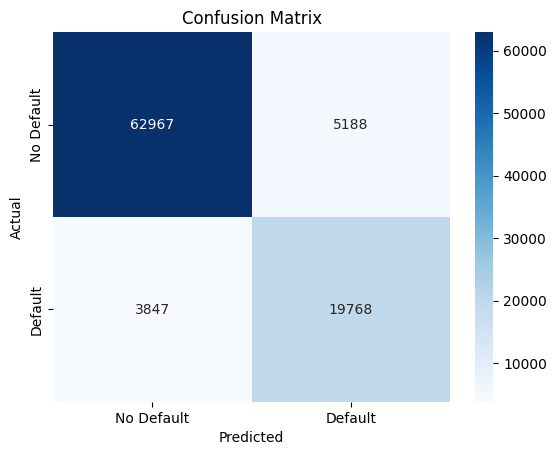

 Best Hyperparameters dictionary saved to 'best_config.npy'


In [4]:

if HYPERPARAMETER_OPT:
    import optuna
    from optuna.trial import TrialState
    
    def objective(trial):
        """
        A function defining the objective function for conducting hyperparameter optimization
        for a our default detection model using Optuna.
        The performance metric to be optimized (maximized ) is the AMEX industry metric (top 4% and Gini coef average).
        """
        config = {
            "embed_dim": trial.suggest_categorical("embed_dim", [64, 128, 256]),
            "input_dim": 221,
            "num_heads": trial.suggest_categorical("num_heads", [4, 8, 16]),
            "ff_dim": trial.suggest_categorical("ff_dim", [256, 512, 1024]),
            "num_blocks": trial.suggest_int("num_blocks", 2, 6),
            "dropout": trial.suggest_float("dropout", 0.1, 0.5),
            "batch_size": trial.suggest_categorical("batch_size", [128, 256, 512]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
            "patience": 5,
            "num_epochs": 10,
            "model_save_path": f"/kaggle/working/best_transformer_model_trial_{trial.number}.pth",
            "threshold": 0.5
        }
    
        model, predictions, actuals = train_and_evaluate(config)
        amex_score = amex_metric_mod(actuals, predictions)
        return amex_score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    
    print("Number of completed trials:", len(study.trials))
    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value: {best_trial.value}")
    print("  Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    best_config = {
        "embed_dim": best_trial.params["embed_dim"],
        "input_dim": 221,
        "num_heads": best_trial.params["num_heads"],
        "ff_dim": best_trial.params["ff_dim"],
        "num_blocks": best_trial.params["num_blocks"],
        "dropout": best_trial.params["dropout"],
        "batch_size": best_trial.params["batch_size"],
        "learning_rate": best_trial.params["learning_rate"],
        "weight_decay": best_trial.params["weight_decay"],
        "patience": 5,
        "num_epochs": 10,
        "model_save_path": "/kaggle/working/best_transformer_model_final.pth",
        "threshold": 0.5
    }
    
    model, predictions, actuals = train_and_evaluate(best_config)
    
    platt_scaler = LogisticRegression()
    platt_scaler.fit(predictions.reshape(-1, 1), actuals)
    calibrated_probs = platt_scaler.predict_proba(predictions.reshape(-1, 1))[:, 1]
    
    binary_preds = (calibrated_probs >= best_config["threshold"]).astype(int)
    cm = confusion_matrix(actuals, binary_preds)
    print(f"Final AMEX Metric: {amex_metric_mod(actuals, calibrated_probs):.4f}")
    print(f"Precision: {precision_score(actuals, binary_preds):.4f}")
    print(f"Recall: {recall_score(actuals, binary_preds):.4f}")
    print(f"F1-Score: {f1_score(actuals, binary_preds):.4f}")
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


    # Save the Best Hyperparameters dictionary to an .npy file
    np.save('/kaggle/working/best_config.npy', best_config)
    
    print(" Best Hyperparameters dictionary saved to 'best_config.npy'")
